### 基于关联规则算法实现电影推荐系统
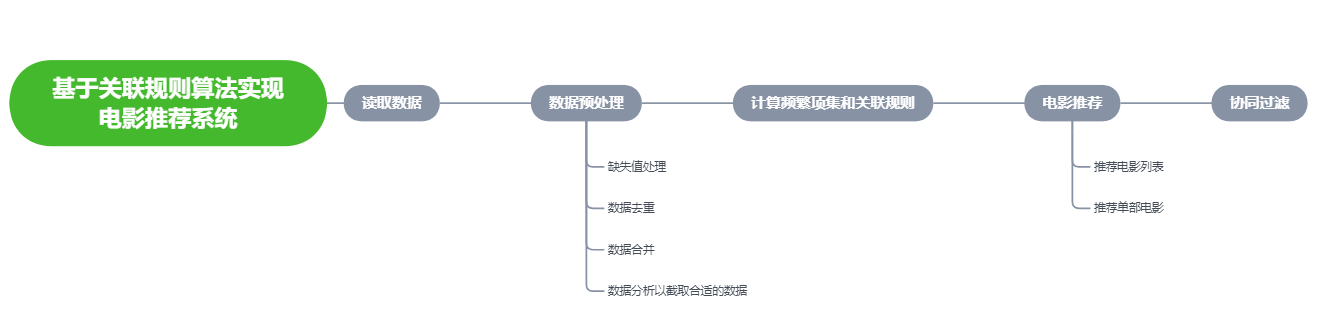
- 利用数据挖掘算法中的Apriori(关联规则)算法来实现一个电影推荐系统
  - 加载数据
  - 数据预处理
  - 生成频繁项集、关联规则
- 通过关联规则生成电影推荐的列表

### Apriori算法
- **案例：** 
 啤酒与尿布:  沃尔玛超市在分析销售记录时，发现了啤酒与尿布经常一起被购买，于是他们调整了货架将两者放在了一起，结果真的提升了啤酒的销量。  原因解释: 爸爸在给宝宝买尿布的时候，会顺便给自己买点啤酒？
- **概述：**
 Apriori算法是一种最有影响力的挖掘布尔关联规则的频繁项集的算法，其命名Apriori源于算法使用了频繁项集性质的先验(Prior)知识。
 接下来我们将以超市订单的例子理解关联分析相关的重要概念: Support(支持度)、Confidence(置信度)、Lift(提升度）。
 
  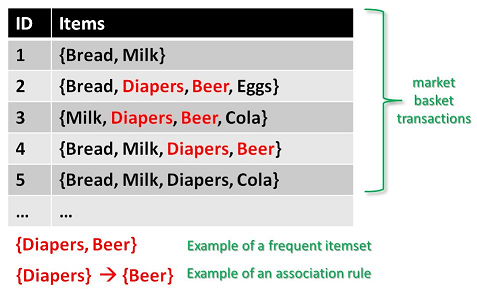
  
  - Support(支持度)：指某事件出现的概率，在本例中即指某个商品组合出现的次数占总次数的比例。
  
  例：Support('Bread') = 4/5 = 0.8 Support('Milk') = 4/5 = 0.8
     Support('Bread+Milk') = 3/5 = 0.6  
     
  - Confidence(置信度)：本质上是个条件概率，即当购买了商品A的前提下，购买商品B的概率。
  
  例：Confidence('Bread'—> 'Milk') = Support('Bread+Milk')/ Support('Bread') = 0.6/0.8 = 0.75  
  
  - Lift(提升度）: 指商品A的出现，对商品B的出现的概率的提升程度。Lift(A->B) = Confidence(A, B) / Support(B)
  
  例：Lift('Bread'—> 'Milk') = 0.75/0.8 = 0.9375 

- **对于Lift(提升度）有三种情况：**
  - Lift(A->B)>1: 代表A对B的出现概率有提升。
  - Lift(A->B)=1: 代表A对B的出现概率没有提升，也没有下降。
  - Lift(A->B)<1: 代表A对B的出现概率有下降效果。
  
- **原理：**
 该算法挖掘关联规则的过程，即是查找频繁项集(frequent itemset)的过程:
   - 频繁项集：支持度大于等于最小支持度(Min Support)阈值的项集。
   - 非频繁集：支持度小于最小支持度的项集。

- **流程：**
 K = 1, 计算K项集的支持度；
 筛选掉小于最小支持度的项集；
 如果项集为空，则对应K-1项集的结果为最终结果。否则K = K+1重复2-3步

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mlxtend
import numpy as np

#### 电影数据准备

In [2]:
movie_data_file = './movie_dataset/movies_metadata.csv'
ratings_file = './movie_dataset/ratings_small.csv'

In [3]:
movie_data_df = pd.read_csv(movie_data_file)
ratings_df = pd.read_csv(ratings_file)

c:\users\ysilhouette\documents\pyenv\py3.6.5\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
movie_data_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
movie_data_df.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [6]:
movie_data_df.info

<bound method DataFrame.info of        adult                              belongs_to_collection    budget  \
0      False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1      False                                                NaN  65000000   
2      False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3      False                                                NaN  16000000   
4      False  {'id': 96871, 'name': 'Father of the Bride Col...         0   
...      ...                                                ...       ...   
45461  False                                                NaN         0   
45462  False                                                NaN         0   
45463  False                                                NaN         0   
45464  False                                                NaN         0   
45465  False                                                NaN         0   

                                           

In [7]:
movie_data_df.count()

adult                    45466
belongs_to_collection     4494
budget                   45466
genres                   45466
homepage                  7782
id                       45466
imdb_id                  45449
original_language        45455
original_title           45466
overview                 44512
popularity               45461
poster_path              45080
production_companies     45463
production_countries     45463
release_date             45379
revenue                  45460
runtime                  45203
spoken_languages         45460
status                   45379
tagline                  20412
title                    45460
video                    45460
vote_average             45460
vote_count               45460
dtype: int64

In [8]:
movie_data_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [9]:
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [10]:
ratings_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [11]:
ratings_df.count()

userId       100004
movieId      100004
rating       100004
timestamp    100004
dtype: int64

In [12]:
ratings_df.shape

(100004, 4)

In [13]:
movie_data_df.shape

(45466, 24)

#### 数据预处理
- 缺失值处理
- 数据去重
- 电影源信息 merge 电影评分信息

In [14]:
movie_data_df_t=movie_data_df[['title','id']]

In [15]:
movie_data_df_t.dtypes

title    object
id       object
dtype: object

In [16]:
ratings_df_s = ratings_df.drop(['timestamp'], axis=1)  #axis=0 跨列删除行 ，axis=1 跨行删除列

In [17]:
ratings_df_s.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

##### 缺失值处理
- pandas中用NaN(Not a Number)表示浮点数和非浮点数数组中的缺失值，同时python中None值也被当作缺失值。

In [18]:
# pd.to_numeric 将id列 的数据 由字符串转为数值类型， 不能转换的数据设置为NaN
pd.to_numeric(movie_data_df_t['id'],errors='coerce')

0           862.0
1          8844.0
2         15602.0
3         31357.0
4         11862.0
           ...   
45461    439050.0
45462    111109.0
45463     67758.0
45464    227506.0
45465    461257.0
Name: id, Length: 45466, dtype: float64

In [19]:
#np.where返回满足（）内条件的数据所在的位置
np.where(pd.to_numeric(movie_data_df_t['id'], errors='coerce').isna()) #返回缺失值的位置，其中isna() 对于NaN返回True，否则返回False

(array([19730, 29503, 35587], dtype=int64),)

- **loc works on labels in the index.**
  - loc为Selection by Label函数，即为按标签取数据，标签是什么，就是上面的’0’~‘4’, ‘A’~‘B’。
  - 例如第一个参数选择index，第二个参数选择column 
  - 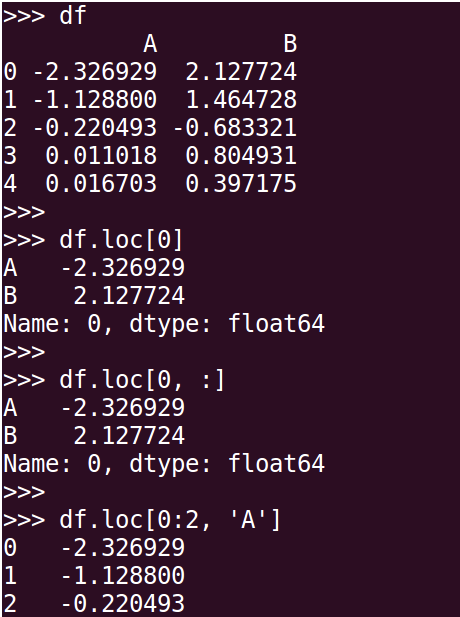
  - 建议写df.loc[0, :]，这样可以清楚的看出为第0行的所有记录，同样如果取第’A’列的所有记录，可以写df.loc[:, ‘A’]，如下图：
  - 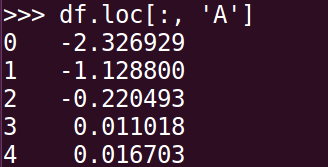
  - :表示所有，[]里边为先行后列
- **iloc works on the positions in the index (so it only takes integers).**
  - iloc函数为Selection by Position，即按位置选择数据，即第n行，第n列数据，只接受整型参数, 比如 0:2为左闭右开区间，即取0，1
  - 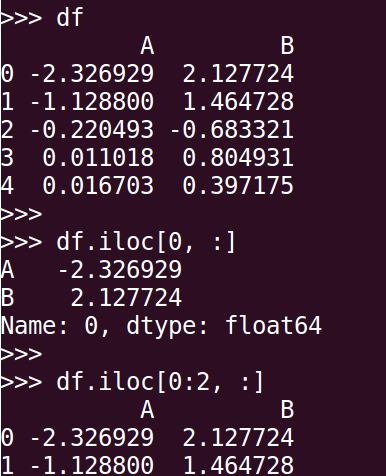
  - 若要取第一列的所有数据，则为df.iloc[:, 0]，不接受’A’作为参数
  - 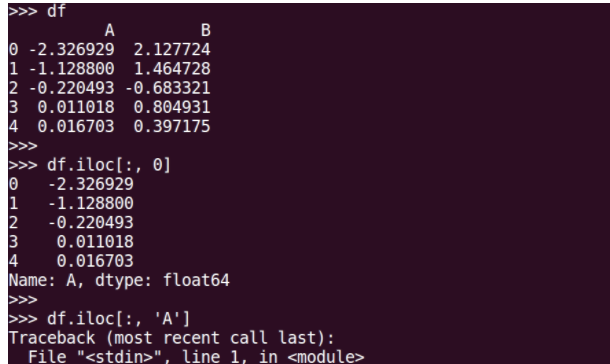

In [20]:
movie_data_df_t.iloc[19730]

title           NaN
id       1997-08-20
Name: 19730, dtype: object

In [21]:
movie_data_df_t.iloc[[19730,29503,35587]]

,title,id
19730,NaN,1997-08-20
29503,NaN,2012-09-29
35587,NaN,2014-01-01


In [22]:
# 将格式转换后的数据 赋值给id列
movie_data_df_t['id'] = pd.to_numeric(movie_data_df_t['id'], errors='coerce')

c:\users\ysilhouette\documents\pyenv\py3.6.5\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
movie_data_df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   45460 non-null  object 
 1   id      45463 non-null  float64
dtypes: float64(1), object(1)
memory usage: 710.5+ KB


In [24]:
movie_data_df_t.iloc[[19730,29503,35587]]

,title,id
19730,NaN,NaN
29503,NaN,NaN
35587,NaN,NaN


In [25]:
movie_data_df_t.shape

(45466, 2)

In [26]:
movie_data_df_t.drop(np.where(movie_data_df_t['id'].isna())[0], inplace=True)

c:\users\ysilhouette\documents\pyenv\py3.6.5\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
movie_data_df_t.shape

(45463, 2)

##### 数据去重

In [28]:
movie_data_df_t.duplicated(['id','title']).sum()

30

In [29]:
movie_data_df_t.drop_duplicates(['id'],inplace=True)

c:\users\ysilhouette\documents\pyenv\py3.6.5\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
movie_data_df_t.shape

(45433, 2)

In [31]:
ratings_df_s.duplicated(['userId','movieId']).sum()

0

In [32]:
movie_data_df_t['id'] = movie_data_df_t['id'].astype(np.int64)

c:\users\ysilhouette\documents\pyenv\py3.6.5\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
movie_data_df_t.dtypes

title    object
id        int64
dtype: object

In [34]:
ratings_df_s.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

### 数据合并

In [35]:
# 左dataframe 和 右dataframe 根据 movieId 和 id进行合并
ratings_df_s = pd.merge(ratings_df_s,movie_data_df_t, left_on='movieId',right_on='id')

In [36]:
ratings_df_s.head()

,userId,movieId,rating,title,id
0,1,1371,2.5,Rocky III,1371
1,4,1371,4.0,Rocky III,1371
2,7,1371,3.0,Rocky III,1371
3,19,1371,4.0,Rocky III,1371
4,21,1371,3.0,Rocky III,1371


In [37]:
ratings_df_s.drop(['id'],axis=1,inplace=True)

In [38]:
ratings_df_s

,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III
...,...,...,...,...
44984,652,129009,4.0,Love Is a Ball
44985,653,2103,3.0,Solaris
44986,659,167,4.0,K-PAX
44987,659,563,3.0,Starship Troopers


In [39]:
ratings_df_s.shape

(44989, 4)

In [40]:
# 有评分记录的电影的个数
len(ratings_df_s['title'].unique())

2794

In [41]:
ratings_df_s['title'].unique()

array(['Rocky III', 'Greed', 'American Pie', ..., 'K-PAX',
       'Starship Troopers', 'Spirited Away'], dtype=object)

In [42]:
ratings_df_s.groupby([ratings_df_s['title'],ratings_df_s['rating']]).count().reset_index()

,title,rating,userId,movieId
0,!Women Art Revolution,3.0,1,1
1,!Women Art Revolution,3.5,1,1
2,'Gator Bait,0.5,1,1
3,'Twas the Night Before Christmas,3.5,1,1
4,'Twas the Night Before Christmas,4.5,1,1
...,...,...,...,...
10263,À nos amours,4.0,5,5
10264,À nos amours,4.5,1,1
10265,À nos amours,5.0,1,1
10266,Ödipussi,4.5,1,1


In [43]:
ratings_df_s.groupby(ratings_df_s['title']).count().reset_index()

,title,userId,movieId,rating
0,!Women Art Revolution,2,2,2
1,'Gator Bait,1,1,1
2,'Twas the Night Before Christmas,2,2,2
3,...And God Created Woman,1,1,1
4,00 Schneider - Jagd auf Nihil Baxter,2,2,2
...,...,...,...,...
2789,xXx,28,28,28
2790,¡Three Amigos!,1,1,1
2791,À nos amours,14,14,14
2792,Ödipussi,1,1,1


In [44]:
ratings_df_s_allcounts = ratings_df_s.groupby(ratings_df_s['title'])['userId'].count().reset_index()

In [45]:
ratings_df_s_allcounts = ratings_df_s_allcounts.rename(columns = {'userId':'totalRatings'})

In [46]:
ratings_df_s_allcounts

,title,totalRatings
0,!Women Art Revolution,2
1,'Gator Bait,1
2,'Twas the Night Before Christmas,2
3,...And God Created Woman,1
4,00 Schneider - Jagd auf Nihil Baxter,2
...,...,...
2789,xXx,28
2790,¡Three Amigos!,1
2791,À nos amours,14
2792,Ödipussi,1


In [47]:
ratings_df_s_allcounts.shape

(2794, 2)

In [48]:
ratings_df_s_allcounts['totalRatings'].describe()

count    2794.000000
mean       16.102004
std        31.481795
min         1.000000
25%         1.000000
50%         4.000000
75%        15.750000
max       324.000000
Name: totalRatings, dtype: float64

array([[<AxesSubplot:title={'center':'totalRatings'}>]], dtype=object)

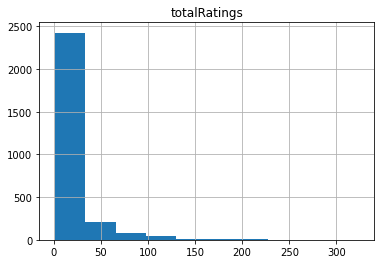

In [49]:
ratings_df_s_allcounts.hist()

In [50]:
ratings_df_s_allcounts['totalRatings'].quantile(np.arange(0.6,1, 0.01)) #分位点

0.60      7.00
0.61      7.00
0.62      7.00
0.63      8.00
0.64      8.00
0.65      9.00
0.66      9.00
0.67     10.00
0.68     10.00
0.69     11.00
0.70     12.00
0.71     12.00
0.72     13.00
0.73     14.00
0.74     14.00
0.75     15.75
0.76     17.00
0.77     18.00
0.78     19.00
0.79     20.00
0.80     21.00
0.81     22.33
0.82     24.00
0.83     26.00
0.84     27.00
0.85     29.00
0.86     31.00
0.87     34.00
0.88     37.00
0.89     41.77
0.90     45.00
0.91     49.00
0.92     52.56
0.93     59.00
0.94     64.42
0.95     71.00
0.96     83.28
0.97     98.21
0.98    119.14
0.99    168.49
Name: totalRatings, dtype: float64

- **从分位点数据分析可以看出，21%的电影 评分记录数超过20个**

In [51]:
votes_count_threshold = 20

In [52]:
ratings_df_s_top=ratings_df_s_allcounts.query('totalRatings > @votes_count_threshold').reset_index()

In [53]:
ratings_df_s_top

,index,title,totalRatings
0,18,"20,000 Leagues Under the Sea",89
1,19,2001: A Space Odyssey,87
2,24,24 Hour Party People,22
3,26,28 Days Later,26
4,27,28 Weeks Later,47
...,...,...,...
575,2770,Young Adam,34
576,2772,Young Frankenstein,29
577,2774,Young and Innocent,193
578,2781,Zatoichi,61


In [54]:
ratings_df_s_top.drop(['index'],axis=1,inplace=True)

In [55]:
ratings_df_s_top.head()

,title,totalRatings
0,"20,000 Leagues Under the Sea",89
1,2001: A Space Odyssey,87
2,24 Hour Party People,22
3,28 Days Later,26
4,28 Weeks Later,47


In [56]:
ratings_df_s['title']

0                Rocky III
1                Rocky III
2                Rocky III
3                Rocky III
4                Rocky III
               ...        
44984       Love Is a Ball
44985              Solaris
44986                K-PAX
44987    Starship Troopers
44988        Spirited Away
Name: title, Length: 44989, dtype: object

In [57]:
ratings_df_s_top['title']

0      20,000 Leagues Under the Sea
1             2001: A Space Odyssey
2              24 Hour Party People
3                     28 Days Later
4                    28 Weeks Later
                   ...             
575                      Young Adam
576              Young Frankenstein
577              Young and Innocent
578                        Zatoichi
579                             xXx
Name: title, Length: 580, dtype: object

In [58]:
ratings_df_s[ratings_df_s['title'].isin(ratings_df_s_top['title'])]

,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III
...,...,...,...,...
44507,624,3057,4.0,Frankenstein
44781,547,97936,3.0,Sweet November
44782,624,97936,3.0,Sweet November
44909,609,1450,5.0,Blood: The Last Vampire


In [59]:
ratings_df_s[ratings_df_s['title'].isin(ratings_df_s_top['title'])]  #得到评分数量大于20的

,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III
...,...,...,...,...
44507,624,3057,4.0,Frankenstein
44781,547,97936,3.0,Sweet November
44782,624,97936,3.0,Sweet November
44909,609,1450,5.0,Blood: The Last Vampire


In [60]:
ratings_df_s[~ratings_df_s['title'].isin(ratings_df_s_top['title'])] # 得到评分数量小于20的

,userId,movieId,rating,title
1714,2,248,3.0,Pocketful of Miracles
1715,36,248,2.0,Pocketful of Miracles
1716,110,248,4.0,Pocketful of Miracles
1717,239,248,4.0,Pocketful of Miracles
1718,242,248,3.0,Pocketful of Miracles
...,...,...,...,...
44983,652,127728,5.0,8:46
44984,652,129009,4.0,Love Is a Ball
44986,659,167,4.0,K-PAX
44987,659,563,3.0,Starship Troopers


In [61]:
ratings_df_s_cntD20 = ratings_df_s[ratings_df_s['title'].isin(ratings_df_s_top['title'])]

In [62]:
ratings_df_s_cntX20 = ratings_df_s[~ratings_df_s['title'].isin(ratings_df_s_top['title'])]

In [63]:
ratings_df_s_cntD20.shape

(34552, 4)

In [64]:
ratings_df_s_cntX20.shape

(10437, 4)

In [65]:
ratings_df_s_cntD20.isna().sum() #检查有无缺失值

userId     0
movieId    0
rating     0
title      0
dtype: int64

In [66]:
ratings_df_s_cntD20.duplicated(['userId','title']).sum()

140

In [67]:
ratings_df_s_cntD20=ratings_df_s_cntD20.drop_duplicates(['userId','title']) # 只保留每个用户对每个电影的一条评论记录

In [68]:
ratings_df_s_cntD20

,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III
...,...,...,...,...
44506,472,3057,3.0,Frankenstein
44507,624,3057,4.0,Frankenstein
44782,624,97936,3.0,Sweet November
44909,609,1450,5.0,Blood: The Last Vampire


In [69]:
ratings_df_s_cntD20.duplicated(['userId','title']).sum()

0

In [70]:
# 将一个dataframe的记录数据整合成表格，而且是按照pivot(‘index=xx’,’columns=xx’,’values=xx’)来整合的。还有另外一种写法，就是pivot(‘索引列’，‘列名’，‘值’)。
ratings_df_s_cntD20_for_apriori = ratings_df_s_cntD20.pivot(index='userId',columns='title',values='rating')

In [71]:
ratings_df_s_cntD20_for_apriori

title,"20,000 Leagues Under the Sea",2001: A Space Odyssey,24 Hour Party People,28 Days Later,28 Weeks Later,300,48 Hrs.,5 Card Stud,7 Virgins,8 Women,...,Within the Woods,X-Men Origins: Wolverine,Y Tu Mamá También,Yankee Doodle Dandy,Yesterday,Young Adam,Young Frankenstein,Young and Innocent,Zatoichi,xXx
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
ratings_df_s_cntD20_for_apriori= ratings_df_s_cntD20_for_apriori.fillna(0) #缺失值 填充0

In [73]:
def encode_units(x): # 有效评分规则， 1表示有效，0 表示无效
    if x <= 0:
        return 0
    if x>0:
        return 1

In [74]:
ratings_df_s_cntD20_for_apriori = ratings_df_s_cntD20_for_apriori.applymap(encode_units)

### 计算频繁项集  和关联规则

In [75]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [76]:
ratings_df_s_cntD20_for_apriori.head()

title,"20,000 Leagues Under the Sea",2001: A Space Odyssey,24 Hour Party People,28 Days Later,28 Weeks Later,300,48 Hrs.,5 Card Stud,7 Virgins,8 Women,...,Within the Woods,X-Men Origins: Wolverine,Y Tu Mamá También,Yankee Doodle Dandy,Yesterday,Young Adam,Young Frankenstein,Young and Innocent,Zatoichi,xXx
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [77]:
ratings_df_s_cntD20_for_apriori.isna().sum() #检查是否有nan值

title
20,000 Leagues Under the Sea    0
2001: A Space Odyssey           0
24 Hour Party People            0
28 Days Later                   0
28 Weeks Later                  0
                               ..
Young Adam                      0
Young Frankenstein              0
Young and Innocent              0
Zatoichi                        0
xXx                             0
Length: 580, dtype: int64

In [78]:
frequent_itemsets = apriori(ratings_df_s_cntD20_for_apriori, min_support=0.10, use_colnames=True)  #生成符合条件的频繁项集

In [79]:
frequent_itemsets.sort_values('support',ascending=False)  #support降序排列的频繁项集

,support,itemsets
111,0.482861,(Terminator 3: Rise of the Machines)
130,0.463487,(The Million Dollar Hotel)
105,0.454545,(Solaris)
113,0.433681,(The 39 Steps)
69,0.408346,(Monsoon Wedding)
...,...,...
1613,0.101341,"(Sleepless in Seattle, 5 Card Stud, The Tunnel)"
5455,0.101341,"(Beauty and the Beast, Rain Man, Terminator 3:..."
5454,0.101341,"(The Passion of Joan of Arc, Beauty and the Be..."
6769,0.101341,"(The Million Dollar Hotel, The Hours, Three Co..."


In [80]:
rules= association_rules(frequent_itemsets, metric="lift", min_threshold=1)  #生成关联规则，只保留lift>1的部分
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(5 Card Stud),(48 Hrs.),0.298063,0.298063,0.108793,0.365000,1.224575,0.019952,1.105413
1,(48 Hrs.),(5 Card Stud),0.298063,0.298063,0.108793,0.365000,1.224575,0.019952,1.105413
2,(A Clockwork Orange),(48 Hrs.),0.152012,0.298063,0.102832,0.676471,2.269559,0.057523,2.169625
3,(48 Hrs.),(A Clockwork Orange),0.298063,0.152012,0.102832,0.345000,2.269559,0.057523,1.294638
4,(48 Hrs.),(A Nightmare on Elm Street),0.298063,0.268256,0.156483,0.525000,1.957083,0.076526,1.540513
...,...,...,...,...,...,...,...,...,...
75531,(The Hours),"(The Million Dollar Hotel, Terminator 3: Rise ...",0.301043,0.126677,0.104322,0.346535,2.735585,0.066187,1.336449
75532,(Terminator 3: Rise of the Machines),"(The Million Dollar Hotel, The Hours, Rain Man...",0.482861,0.114754,0.104322,0.216049,1.882716,0.048912,1.129211
75533,(Rain Man),"(The Million Dollar Hotel, The Hours, Terminat...",0.295082,0.120715,0.104322,0.353535,2.928669,0.068701,1.360143
75534,(Sissi),"(The Million Dollar Hotel, The Hours, Terminat...",0.317437,0.117735,0.104322,0.328638,2.791347,0.066949,1.314143


In [81]:
rules.sort_values('lift',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1473,(Muxmäuschenstill),(Waiter),0.156483,0.120715,0.105812,0.676190,5.601529,0.086922,2.715438
1472,(Waiter),(Muxmäuschenstill),0.120715,0.156483,0.105812,0.876543,5.601529,0.086922,6.832489
38208,"(Titanic, Big Fish)","(Psycho, Rain Man)",0.150522,0.131148,0.101341,0.673267,5.133663,0.081601,2.659215
38209,"(Psycho, Rain Man)","(Titanic, Big Fish)",0.131148,0.150522,0.101341,0.772727,5.133663,0.081601,3.737705
38238,"(Titanic, Big Fish)","(Psycho, Solaris)",0.150522,0.134128,0.102832,0.683168,5.093399,0.082642,2.732908
...,...,...,...,...,...,...,...,...,...
108,(5 Card Stud),(Men in Black II),0.298063,0.333830,0.110283,0.370000,1.108348,0.010781,1.057413
571,"(Bang, Boom, Bang)",(The 39 Steps),0.260805,0.433681,0.125186,0.480000,1.106804,0.012080,1.089075
570,(The 39 Steps),"(Bang, Boom, Bang)",0.433681,0.260805,0.125186,0.288660,1.106804,0.012080,1.039159
1137,(Sissi),(License to Wed),0.317437,0.301043,0.102832,0.323944,1.076070,0.007269,1.033874


- **结果说明：上述输出的即为所有关联规则的结果，每一行代表一个关联规则，其中行号1473所在的关联规则(Waiter->Muxmauschenstill)关联度最高(conviction值越大，代表antecedents与consequents的关联度越大）)。**

## 电影推荐

#### 推荐电影列表

In [82]:
all_antecedents = [list(x) for x in rules['antecedents'].values]

In [83]:
desired_indices = [i for i in range(len(all_antecedents)) if len(all_antecedents[i]) == 1 and all_antecedents[i][0] == 'Batman Returns'] 

In [84]:
apriori_recommendations =rules.iloc[desired_indices,].sort_values(by=['lift'],ascending=False)

In [85]:
apriori_recommendations.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
63981,(Batman Returns),"(The Hours, Monsoon Wedding, Silent Hill, Rese...",0.298063,0.107303,0.102832,0.345,3.215208,0.070849,1.362897
36084,(Batman Returns),"(Reservoir Dogs, Wag the Dog, Silent Hill)",0.298063,0.105812,0.101341,0.340,3.213239,0.069803,1.354830
63891,(Batman Returns),"(Monsoon Wedding, Silent Hill, Reservoir Dogs,...",0.298063,0.107303,0.101341,0.340,3.168611,0.069358,1.352572
63351,(Batman Returns),"(Monsoon Wedding, Silent Hill, Reservoir Dogs,...",0.298063,0.107303,0.101341,0.340,3.168611,0.069358,1.352572
36014,(Batman Returns),"(The Hours, Reservoir Dogs, Silent Hill)",0.298063,0.116244,0.108793,0.365,3.139936,0.074145,1.391741


In [86]:
apriori_recommendations_list = [list(x) for x in apriori_recommendations['consequents'].values]

In [87]:
print("Apriori Recommendations for movie: Batman Returns\n")
for i in range(5):
    print("{0}:{1} with lift of {2}" .format(i+1, apriori_recommendations_list[i], apriori_recommendations.iloc[i,6]))

Apriori Recommendations for movie: Batman Returns

1:['The Hours', 'Monsoon Wedding', 'Silent Hill', 'Reservoir Dogs'] with lift of 3.215208333333333
2:['Reservoir Dogs', 'Wag the Dog', 'Silent Hill'] with lift of 3.2132394366197183
3:['Monsoon Wedding', 'Silent Hill', 'Reservoir Dogs', 'Sissi'] with lift of 3.168611111111111
4:['Monsoon Wedding', 'Silent Hill', 'Reservoir Dogs', 'Rain Man'] with lift of 3.168611111111111
5:['The Hours', 'Reservoir Dogs', 'Silent Hill'] with lift of 3.139935897435898


#### 推荐单部电影

In [88]:
apriori_single_recommendations = apriori_recommendations.iloc[[x for x in range(len(apriori_recommendations_list)) if len(apriori_recommendations_list[x]) ==1],]

In [90]:
apriori_single_recommendations_list = [list(x) for x in apriori_single_recommendations['consequents'].values]

In [91]:
print("Apriori single-movie Recommendations for movie: Batman Returns\n")
for i in range(5):
    print("{0}: {1}, with lift of {2}".format(i+1,apriori_single_recommendations_list[i][0],apriori_single_recommendations.iloc[i,6]))

Apriori single-movie Recommendations for movie: Batman Returns

1: Reservoir Dogs, with lift of 2.6094444444444447
2: Ariel, with lift of 2.5397663551401872
3: Wag the Dog, with lift of 2.496744186046512
4: To Kill a Mockingbird, with lift of 2.478125
5: Romeo + Juliet, with lift of 2.4705000000000004


- **结果说明：我们约束consequents(后件)的长度为1，选出lift降序排列的前五个关联规则(关联规则格式为前件——>后件）。对于用户观看的电影记录《Batman Returns》，即antecedents(前件），我们根据规则按照推荐程度降序给出了单部电影推荐结果**

## **协同过滤**

#### 基于user的协同过滤

- 在海量的用户中发现一小部分和你品味比较相近的，在协同过滤中，这些用户称为邻居，然后根据他们喜欢的东西组织成一个排序的目录来推荐给你
   -  **重点就是怎样去寻找和你比较相似的用户，怎么将那些邻居的喜好组织成一个排序的目录给用户**
      - 在世纪钟给出一个数字K表示和你最为相似的用户。
      - 在计算相似度的时候，理论上要计算被推荐的用户与所有用户的相似度，但是当数据量比较大的时候，这样做是很费时间的 ，
      - 数据集中可能有很多用户和需要被推荐的用户是没有关系的， 在计算是完全是没有必要的，
      - 所以需要物品到用户的反查表，也就是没一件物品对应的用户信息，有了这个表，就可以过滤掉很多和你没有关系的用户，减少计算量。
      - 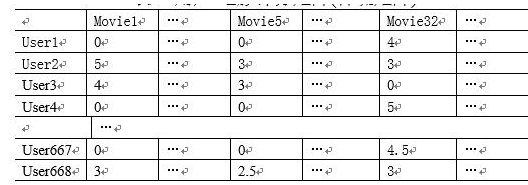
  - 总结来说，推荐的过程就是先计算用户之间的相似度，根据相似度的高低选取前K个用户，在这K个用户中计算每一件物品的推荐程度。

In [92]:
# 读取ratings_small.csv数据用于建模
ratings_small_path = "./movie_dataset/ratings_small.csv"
ratings_small_df = pd.read_csv(ratings_small_path)

In [93]:
ratings_small_df.shape

(100004, 4)

In [94]:
ratings_small_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [95]:
# 原始的movieId 并非从0到1 的连续值， 为方便更贱user-item矩阵， 重新排列movie_id
movie_id = ratings_small_df['movieId'].drop_duplicates()
movie_id = pd.DataFrame(movie_id)
movie_id['movieid'] = range(len(movie_id))

In [96]:
movie_id

,movieId,movieid
0,31,0
1,1029,1
2,1061,2
3,1129,3
4,1172,4
...,...,...
99131,64997,9061
99159,72380,9062
99274,129,9063
99678,4736,9064


In [97]:
ratings_small_df = pd.merge(ratings_small_df, movie_id, on =['movieId'], how='left')
ratings_small_df

,userId,movieId,rating,timestamp,movieid
0,1,31,2.5,1260759144,0
1,1,1029,3.0,1260759179,1
2,1,1061,3.0,1260759182,2
3,1,1129,2.0,1260759185,3
4,1,1172,4.0,1260759205,4
...,...,...,...,...,...
99999,671,6268,2.5,1065579370,7005
100000,671,6269,4.0,1065149201,4771
100001,671,6365,4.0,1070940363,1329
100002,671,6385,2.5,1070979663,1331


In [98]:
ratings_small_df = ratings_small_df[['userId','movieid','rating','timestamp']]  #更新 movieId ----> movieid
ratings_small_df

,userId,movieid,rating,timestamp
0,1,0,2.5,1260759144
1,1,1,3.0,1260759179
2,1,2,3.0,1260759182
3,1,3,2.0,1260759185
4,1,4,4.0,1260759205
...,...,...,...,...
99999,671,7005,2.5,1065579370
100000,671,4771,4.0,1065149201
100001,671,1329,4.0,1070940363
100002,671,1331,2.5,1070979663


In [99]:
# 用户物品统计
# unique()是以 数组形式（numpy.ndarray）返回列的所有唯一值（特征的所有唯一值）
# nunique() Return number of unique elements in the object.即返回的是唯一值的个数

n_users = ratings_small_df.userId.nunique()
n_users

671

In [100]:
n_items = ratings_small_df.movieid.nunique()
n_items 

9066

In [101]:
# 拆分数据集
from sklearn.model_selection import train_test_split
#按照训练集70% 测试集30%的比例 对数据进行拆分
train_data,test_data = train_test_split(ratings_small_df,test_size= 0.3)

In [102]:
train_data

,userId,movieid,rating,timestamp
69526,481,329,4.0,1437001087
41670,299,917,3.5,1344188856
49260,358,288,2.0,957480147
39317,287,3582,4.0,1470168974
35991,262,2094,3.0,1433899624
...,...,...,...,...
6262,33,1095,2.0,1032769543
8504,56,367,2.0,1467005360
8540,56,1435,4.0,1467006577
77937,542,1496,1.0,1424966216


In [103]:
# 训练集 用户-物品 矩阵
user_item_matrix = np.zeros((n_users,n_items))
user_item_matrix.shape

(671, 9066)

In [104]:
# iterrows() : 将DataFrame迭代成（index ,series）
# iteritems()： 将DataFrame迭代成（列名，series）
# itertuples()： 将DataFrame迭代成元组 
for line in train_data.itertuples():
    user_item_matrix[line[1]-1,line[2]]=line[3]

In [105]:
user_item_matrix

array([[0., 3., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [106]:
user_item_matrix.shape

(671, 9066)

In [107]:
# 构建用户相似矩阵 ---采用余弦距离
from sklearn.metrics.pairwise import pairwise_distances
# 相似度计算 定义余弦距离
user_similarity_m = pairwise_distances(user_item_matrix,metric='cosine')  # 每个用户为1行数据，故此处不需要再进行转置

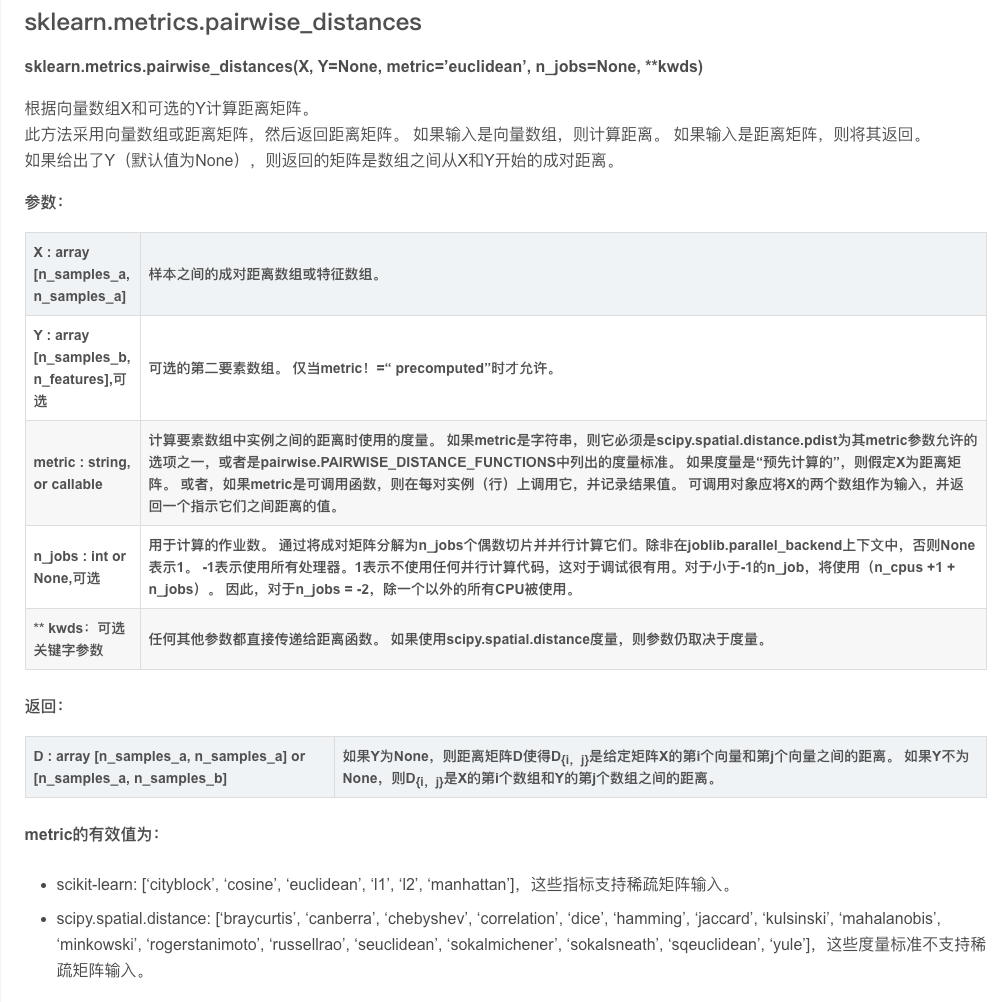

In [108]:
a=[[1,3],[2,2]]
a

[[1, 3], [2, 2]]

In [109]:
pairwise_distances(a,metric='euclidean')

array([[0.        , 1.41421356],
       [1.41421356, 0.        ]])

In [110]:
b = np.array([[1,2],[1,3],[2,1]])
b

array([[1, 2],
       [1, 3],
       [2, 1]])

In [111]:
pairwise_distances(b,metric='euclidean') #结果数组的第一行第二列表示 a[0]与a[1]的距离

array([[0.        , 1.        , 1.41421356],
       [1.        , 0.        , 2.23606798],
       [1.41421356, 2.23606798, 0.        ]])

In [112]:
pairwise_distances(b,metric='cosine')

array([[0.        , 0.01005051, 0.2       ],
       [0.01005051, 0.        , 0.29289322],
       [0.2       , 0.29289322, 0.        ]])

In [113]:
b.shape

(3, 2)

In [114]:
b[1]

array([1, 3])

In [115]:
b[0]

array([1, 2])

In [116]:
user_similarity_m.shape

(671, 671)

In [117]:
user_similarity_m[0:5,0:5].round(2)

array([[0.  , 1.  , 1.  , 0.94, 0.97],
       [1.  , 0.  , 0.89, 0.93, 0.92],
       [1.  , 0.89, 0.  , 0.93, 0.93],
       [0.94, 0.93, 0.93, 0.  , 0.94],
       [0.97, 0.92, 0.93, 0.94, 0.  ]])

In [118]:
user_similarity_m_triu = np.triu(user_similarity_m,k=1) #取得上三角数据
np.round(user_similarity_m_triu[user_similarity_m_triu.nonzero()],3)

array([1.   , 1.   , 0.938, ..., 0.934, 0.919, 0.814])

In [119]:
user_sim_nonzero = np.round(user_similarity_m_triu[user_similarity_m_triu.nonzero()],3)

In [120]:
np.percentile(user_sim_nonzero,np.arange(0,101,10))

array([0.316, 0.844, 0.885, 0.911, 0.93 , 0.947, 0.961, 0.976, 1.   ,
       1.   , 1.   ])

#### 训练集预测

In [121]:
mean_user_rating = user_item_matrix.mean(axis=1)
mean_user_rating

array([0.00297816, 0.0198544 , 0.01301566, 0.06265167, 0.03027796,
       0.01196779, 0.02404589, 0.03805427, 0.01114053, 0.0147805 ,
       0.01047871, 0.01301566, 0.01615928, 0.004743  , 0.33984116,
       0.01069932, 0.0991617 , 0.0147805 , 0.11780278, 0.02294286,
       0.0443415 , 0.04936025, 0.21111846, 0.00683874, 0.00617692,
       0.04031546, 0.00816236, 0.01555261, 0.00363997, 0.29643724,
       0.02625193, 0.01080962, 0.03684094, 0.05702625, 0.0025921 ,
       0.03000221, 0.01147143, 0.03838518, 0.0196338 , 0.01301566,
       0.0592323 , 0.0196338 , 0.02172954, 0.00694904, 0.00512905,
       0.01312597, 0.01069932, 0.14212442, 0.02371498, 0.01169204,
       0.01069932, 0.01941319, 0.00893448, 0.01384293, 0.00838297,
       0.14615045, 0.06254136, 0.01753805, 0.02090227, 0.02018531,
       0.04197   , 0.0172623 , 0.02454225, 0.00739025, 0.00694904,
       0.01544231, 0.02856828, 0.03331127, 0.02327377, 0.02856828,
       0.00794176, 0.05035297, 0.42096845, 0.01544231, 0.03948

In [122]:
rating_diff = (user_item_matrix - mean_user_rating[:,np.newaxis])   # np.newaxis作用：为mean_user_rating增加一个维度，实现加减操作
rating_diff

array([[-2.97816016e-03,  2.99702184e+00,  2.99702184e+00, ...,
        -2.97816016e-03, -2.97816016e-03, -2.97816016e-03],
       [-1.98544011e-02, -1.98544011e-02, -1.98544011e-02, ...,
        -1.98544011e-02, -1.98544011e-02, -1.98544011e-02],
       [-1.30156629e-02, -1.30156629e-02, -1.30156629e-02, ...,
        -1.30156629e-02, -1.30156629e-02, -1.30156629e-02],
       ...,
       [-9.81689830e-03, -9.81689830e-03, -9.81689830e-03, ...,
        -9.81689830e-03, -9.81689830e-03, -9.81689830e-03],
       [-7.16964483e-03, -7.16964483e-03, -7.16964483e-03, ...,
        -7.16964483e-03, -7.16964483e-03, -7.16964483e-03],
       [-3.47452019e-02, -3.47452019e-02, -3.47452019e-02, ...,
        -3.47452019e-02, -3.47452019e-02, -3.47452019e-02]])

In [123]:
user_prediction = mean_user_rating[:,np.newaxis] + user_similarity_m.dot(rating_diff) / np.array([np.abs(user_similarity_m).sum(axis=1)]).T
# 处以np.array([np.abs(item_similarity_m).sum(axis=1)]是为了可以使评分在1~5之间，使1~5的标准化

In [124]:
user_prediction

array([[ 8.48587738e-02,  1.11549860e-01,  7.78496257e-02, ...,
        -3.30873704e-02, -3.59785123e-02, -3.59132569e-02],
       [ 9.36489784e-02,  1.35396758e-01,  1.04357090e-01, ...,
        -1.62815182e-02, -1.93136443e-02, -1.93247190e-02],
       [ 9.44428457e-02,  1.33314515e-01,  9.83052575e-02, ...,
        -2.28228892e-02, -2.58037344e-02, -2.59258365e-02],
       ...,
       [ 9.29750987e-02,  1.27902780e-01,  9.32275326e-02, ...,
        -2.60694824e-02, -2.89101875e-02, -2.87905826e-02],
       [ 8.62056229e-02,  1.26697599e-01,  9.17810994e-02, ...,
        -2.88942031e-02, -3.19119828e-02, -3.20590645e-02],
       [ 1.17342284e-01,  1.50739909e-01,  1.17908253e-01, ...,
        -7.69495365e-05, -2.99819315e-03, -3.02101562e-03]])

In [125]:
# 只取数据集中有评分的数据集进行评估
from sklearn.metrics import mean_squared_error
from math import sqrt

In [126]:
prediction_flatten = user_prediction[user_item_matrix.nonzero()]
prediction_flatten

array([0.11154986, 0.07784963, 0.14877094, ..., 0.04236321, 0.01114962,
       0.02448394])

In [127]:
user_item_matrix_flatten = user_item_matrix[user_item_matrix.nonzero()]
user_item_matrix_flatten

array([3., 3., 2., ..., 4., 4., 4.])

In [128]:
error_test = sqrt(mean_squared_error(prediction_flatten,user_item_matrix_flatten)) # 均方根误差计算

In [129]:
error_test

3.390138302832629